### Import & Setup

In [1]:
import vtk
from vtk.util import numpy_support
import os
import numpy

In [2]:
import plotly
from plotly.graph_objs import *
plotly.plotly.sign_in("somada141", "1t2qb5b9y1")

---

### Tools

We're gonna use this function to quickly convert a `vtkImageData` array to a `numpy.ndarray`

In [3]:
def vtkImageToNumPy(image, pixelDims):
    pointData = image.GetPointData()
    arrayData = pointData.GetArray(0)
    ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
    ArrayDicom = ArrayDicom.reshape(pixelDims, order='F')
    
    return ArrayDicom

We're gonna use this function to quickly plot a 2D array (or slice of a 3D) array with Plotly as a heatmap with a grayscale colormap

In [1]:
def plotHeatmap(array, name="plot"):
    data = Data([
        Heatmap(
            z=array,
            scl='Greys'
        )
    ])
    layout = Layout(
        autosize=False,
        title=name
    )
    fig = Figure(data=data, layout=layout)

    return plotly.plotly.iplot(fig, filename=name)

We're gonna use this function to embed a still image of a VTK render

In [5]:
import vtk
from IPython.display import Image
def vtk_show(renderer, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)

---

### DICOM Input

Load and read-in the DICOM files

In [10]:
PathDicom = "./vhm_head/"
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(PathDicom)
reader.Update()

Read in meta-data

In [11]:
# Load dimensions using `GetDataExtent`
_extent = reader.GetDataExtent()
ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]

# Load spacing values
ConstPixelSpacing = reader.GetPixelSpacing()

It seems that the `vtkDICOMImageReader` automatically rescales the DICOM data to give the Hounsfield Units. If it didn't then this is how you would go about rescaling it

In [12]:
#shiftScale = vtk.vtkImageShiftScale()
#shiftScale.SetScale(reader.GetRescaleSlope())
#shiftScale.SetShift(reader.GetRescaleOffset())
#shiftScale.SetInputConnection(reader.GetOutputPort())
#shiftScale.Update()

# In the next cell you would simply get the output with 'GetOutput' from 'shiftScale' instead of 'reader'

---

Visualize

In [13]:
ArrayDicom = vtkImageToNumPy(reader.GetOutput(), ConstPixelDims)
plotHeatmap(numpy.rot90(ArrayDicom[:, 256, :]), name="CT_Original")

Use the `vtkImageThreshold` to clean all soft-tissue from the image data

In [14]:
threshold = vtk.vtkImageThreshold ()
threshold.SetInputConnection(reader.GetOutputPort())
threshold.ThresholdByLower(400)  # remove all soft tissue
threshold.ReplaceInOn()
threshold.SetInValue(0)  # set all values below 400 to 0
threshold.ReplaceOutOn()
threshold.SetOutValue(1)  # set all values above 400 to 1
threshold.Update()

In [15]:
ArrayDicom = vtkImageToNumPy(threshold.GetOutput(), ConstPixelDims)
plotHeatmap(numpy.rot90(ArrayDicom[:, 256, :]), name="CT_Thresholded")

Use the `vtkDiscreteMarchingCubes` class to extract the surface

In [16]:
%%time
dmc = vtk.vtkDiscreteMarchingCubes()
dmc.SetInputConnection(threshold.GetOutputPort())
dmc.GenerateValues(1, 1, 1)
dmc.Update()

CPU times: user 2.91 s, sys: 53.3 ms, total: 2.97 s
Wall time: 2.99 s


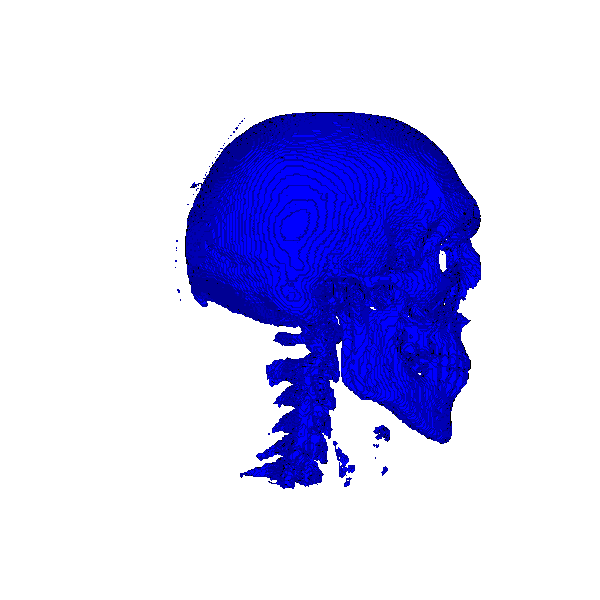

In [17]:
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(dmc.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)

renderer = vtk.vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(1.0, 1.0, 1.0)

camera = renderer.MakeCamera()
camera.SetPosition(-500.0, 245.5, 122.0)
camera.SetFocalPoint(301.0, 245.5, 122.0)
camera.SetViewAngle(30.0)
camera.SetRoll(-90.0)
renderer.SetActiveCamera(camera)
vtk_show(renderer, 600, 600)

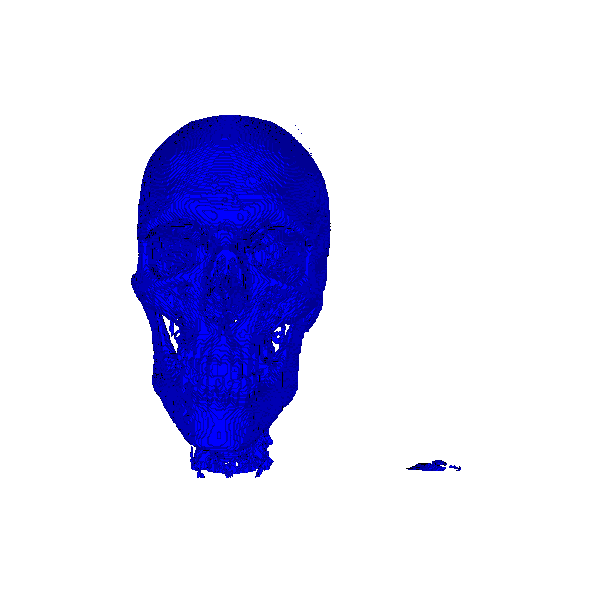

In [18]:
camera = renderer.GetActiveCamera()
camera.SetPosition(301.0, 1045.0, 122.0)
camera.SetFocalPoint(301.0, 245.5, 122.0)
camera.SetViewAngle(30.0)
camera.SetRoll(0.0)
renderer.SetActiveCamera(camera)
vtk_show(renderer, 600, 600)

Save the extracted surface as an .stl file

In [ ]:
writer = vtk.vtkSTLWriter()
writer.SetInputConnection(dmc.GetOutputPort())
writer.SetFileTypeToBinary()
writer.SetFileName("bones.stl")
writer.Write()

In [ ]:
renderer_window = vtk.vtkRenderWindow()
renderer_window.AddRenderer(renderer) 
renderer_interactor = vtk.vtkRenderWindowInteractor()
renderer_interactor.SetRenderWindow(renderer_window)
renderer.SetBackground(1,1,1)
renderer_window.SetSize(1024, 768)

renderer_interactor.Initialize()
renderer_window.Render()
renderer_interactor.Start()